In [57]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
import requests, json
import pandas as pd

In [2]:
NOTION_TOKEN = "secret_yALfcNjUSTZUhld5R8vOlHKaIRnoVORMwzha6Wox8RU"

In [3]:

headers = {
    "Authorization": "Bearer " + NOTION_TOKEN,
    "Content-Type": "application/json",
    "Notion-Version": "2022-06-28",
}

DATABASE_ID_LIST = ["db2b026a03f0442f828bc88dcdbf143c", "c238334399d54b10aad0bcb84cb77d5c", "bf7efa466c624f1ca200d05c5cf34f58", "2f0e230f82974dd09841ae871cb558f9", "b708c8576ea34bb385d24aedc5b1277b", "d6211c2113914ecc86332d4bb305a115", "a8b0289c72eb4daaa1063152eb5e787a", "73e5dc61f97f4f2095c0265f2dae70d8", "1a91276509b246dda4c170a248d096c2", "6a374753947e42f7aa57fac3a474b78f"]
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

def readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers):
    for id in zip(DATABASE_ID_LIST, YEAR_LIST):
        readUrl = f"https://api.notion.com/v1/databases/{id[0]}/query"
        res = requests.request("POST", readUrl, headers=headers)
        data = res.json()
        print(res.status_code)

        if res.status_code == 200:
            try:
                with open(f"./data/{id[1]}.json", 'w', encoding='utf8') as f:
                    json.dump(data, f, ensure_ascii=False)
            except:
                continue
            
readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers)

200
200
200
200
200
200
200
200
200
200


In [4]:
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


def jsonToDataFrame(YEAR_LIST):
    temp = {}
    year_list = []
    name = []
    birth = []
    registered = []
    fullTime = []
    responsibilities = []
    career = []
    stock = []
    time1 = []
    time2 = []
    position = []

    for year in YEAR_LIST:
        with open(f"./data/{year}.json", 'r') as f:
            json_data = json.load(f)
            for i in range(len(json_data['results'])):
                properties = json_data['results'][i]['properties']
                year_list.append(year)
                for key in properties:
                    if key == '이름':
                        name.append(properties[key]['title'][0]['text']['content'])
                    elif key == '출생년월':
                        birth.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '등기임원 여부':
                        registered.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '상근 여부':
                        fullTime.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '담당업무':
                        responsibilities.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '주요경력':
                        career.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '의결권 있는 주식수':
                        stock.append(properties[key]['number'])
                    elif key == '재직기간':
                        time1.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '임기만료일':
                        time2.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '직위':
                        position.append(properties[key]['rich_text'][0]['text']['content'])

    temp['이름'] = name
    temp['연도'] = year_list
    temp['출생년월'] = birth
    temp['등기임원 여부'] = registered
    temp['상근 여부'] = fullTime
    temp['담당업무'] = responsibilities
    temp['주요경력'] = career
    temp['의결권 있는 주식수'] = stock
    temp['재직기간'] = time1
    temp['임기만료일'] = time2
    temp['직위'] = position
    return temp

dict = jsonToDataFrame(YEAR_LIST)

df = pd.DataFrame.from_dict(data=dict, orient='columns')

In [5]:
df['의결권 있는 주식수'].fillna(0.0, inplace=True)
#'\xa0' 처리
df['주요경력']=df['주요경력'].str.replace('\xa0', '')
#대학, 전공 피처 생성
temp=df['주요경력'].str.split('\n')
colleges=temp.str.get(0)

#추가로 처리해줘야될 대학 form 맞춰주기
colleges[colleges== 'University of Bath 사회과학대학원(석사)'] ='UniversityofBath 사회과학대학원(석사)'
colleges[colleges== 'Florida International University 경영대학원(박사)']='FloridaInternationalUniversity 경영대학원(박사)'
colleges[colleges== 'Ohio State University 정책대학원(박사)'] = 'OhioStateUniversity 정책대학원(박사)'
colleges[colleges== 'KDI국제정책대학원(석사)'] = 'KDI 국제정책대학원(석사)'
colleges[colleges== '상명여자사범대'] = '상명여자사범대 교육학'
colleges[colleges== '한국외국어대경영학(석사)'] = '한국외국어대 경영학(석사)'
colleges[colleges== '미시간대학교 경영대학원 MBA'] = '미시간대학교 경영대학원MBA'

#대학, 전공으로 나누기
ttemp = colleges.str.split() 

#대학 피처 생성
df['대학교']=ttemp.str.get(0)

#전공 피처 생성
tttemp = ttemp.str.get(1)
tttemp=tttemp.replace(r'\([^)]*\)', '', regex=True)
df['전공']=tttemp

#근속연수 생성
def create_work_years(x):
  temp = re.split(r'~|~\n', x)
  temp[0] = temp[0].strip()
  temp[1] = temp[1].strip()
  return int(temp[1][:4]) - int(temp[0][:4])

df['근속연수'] = df['재직기간'].apply(lambda x : create_work_years(x))

#주요경력 전처리
def replace_career(x):
  temp = [string.split() for string in re.split(r'\n |\n', x)]
  if len(temp)==1 :
    return {'대신증권'}
  else:
    return set(list(zip(*temp[1:]))[0])

df['주요경력요약'] = df['주요경력'].apply(lambda x : replace_career(x))

In [6]:
df_2014 = df[df['연도']==2014].reset_index(drop=True)
df_2015 = df[df['연도']==2015].reset_index(drop=True)
df_2016 = df[df['연도']==2016].reset_index(drop=True)
df_2017 = df[df['연도']==2017].reset_index(drop=True)
df_2018 = df[df['연도']==2018].reset_index(drop=True)
df_2019 = df[df['연도']==2019].reset_index(drop=True)
df_2020 = df[df['연도']==2020].reset_index(drop=True)
df_2021 = df[df['연도']==2021].reset_index(drop=True)
df_2022 = df[df['연도']==2022].reset_index(drop=True)
df_2023 = df[df['연도']==2023].reset_index(drop=True)

In [7]:
#학교 거리 계산
def cal_college(df1, df2, alpha = 0.7):
  #지역별로 나눔
  college_dict = {'서울경기':['상명여자사범대', '서울대', '홍익대', '성균관대', '연세대', '연세대학교', '동국대', '중앙대', '한국외대', '한국외국어대', '세종대학교', '세종대', '성균관대학교', '경희대', '서강대', '고려대', '건국대', '가천대', '가천대학교', '한양대', '명지대'],
                   '광역시':['부경대', '경북대', '전남대', '조선대', '한국과학기술원', '가천대', '인하대', '동아대', '대전대', '울산대', '영남공업전문대'],
                   '그외한국':['전북대', '원광대', '충북대', '충북대학교', '강원대', 'KDI'],
                   '해외':['FloridaInternationalUniversity', 'OhioStateUniversity', 'UniversityofBath', '조지아공대', 'Brown대', '카네기멜론대', '미시간대학교']}

  #키값 찾기
  for key, val in college_dict.items() :
    if df1['대학교'] in val :
      df1_key = key
    if df2['대학교'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['대학교'] == df2['대학교'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#학과 거리 계산
def cal_department(df1, df2, alpha = 0.7):
  department_dict={'경영경제':['회계학', '세무학', '경제학', '국제경영학', '경영학', '무역학', 'MBA', '경제통상학', '경영대학원', '경영대학원MBA', '산업정보학', '금융공학', '국제금융학'],
                   '사회과학':['사회학', '사회과학대학원', '행정학', '정치외교학', '정치학', '신문방송학'],
                   '법률':['법학', '사법학', '정책대학원', '국제정책대학원'],
                   '인문':['불어불문학'],
                   '기타':['교육학', '인적자원개발학'],
                   '자연':['응용통계학', '통계학', '수학'],
                   '공학':['기계공학', '화학공학', '전자계산학', '전자전산학', '전산학', '항공우주학']}

  #키값 찾기
  for key, val in department_dict.items() :
    if df1['전공'] in val :
      df1_key = key
    if df2['전공'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['전공'] == df2['전공'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#직위 거리 계산
def cal_position(df1, df2, alpha = 0.7):
  position_dict={'회장':0, '대표이사':1, '부회장':2, '사장':3, '부사장':4, '전무':5, '상무': 6, '상무보':7, '이사대우부문장':8, '이사대우담당':8, '사외이사':99, '감사위원':99}

  #value값 찾기
  df1_value = position_dict[df1['직위']]
  df2_value = position_dict[df2['직위']]

  #k값 구하기
  if df1['직위'] == df2['직위'] :
    k=0
  elif df1_value == 99 or df2_value == 99 : #사외이사 혹은 감사인원(회사밖 인물)은 모두와 거리 4(최대차이의 중간값// 회장, 이사대우담당과의 거리)
    k=4
  else :
    k=abs(df1_value - df2_value) #값 차이만큼 거리

  return alpha ** k

# 근속연수 거리 계산
def cal_work_years(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['근속연수'] == df2['근속연수'] :
    k=0
  else :
    if abs(df1['근속연수'] - df2['근속연수']) % 5 ==0:    #근속연수 차이 5년 기준으로 1씩 증가 (차이 1~5/6~10/11~15/...같은그룹)
      k= abs(df1['근속연수'] - df2['근속연수']) // 5 
    else:
      k= 1 + abs(df1['근속연수'] - df2['근속연수']) // 5 

  return alpha ** k  

#담당업무 거리 계산
def cal_task(df1, df2, alpha = 0.7):
  task_dict={'IT계열': {'IT':['IT부문장', 'IT본부장', 'IT서비스본부장', '디지털부문장', '스마트Biz본부장', 'Operation&Technology본부장'], '정보보호':['정보보호부문장', '정보보호담당']},
             '본사영업':{'Wolesale':['Wholesale부문장','Wholesale영업본부장', 'Wholesale사업단장', 'Trading부문장', 'Trading Center장', 'Sales&Trading총괄', '대외협력담당'], 
                     'IB':['IB사업단장', 'IB부문장', 'IB부부문장', 'IB1부문장', 'IB2부문장', 'IPO담당',  'PF부문장', 'PF1본부장', '구조화상품본부장'], 
                     '영업':['영업부장']},
             '본사관리':{'리테일':['리테일총괄', 'Club1962센터장','WM추진부문장', 'WM추진본부장', 'WM사업단장'],
                     '리스크':['리스크관리부문장', '리스크관리담당'] ,
                     '경영':['경영전략총괄', '전략지원부문장', '전략지원담당', '경영지원본부장', '경영지원부문장', '경영기획부문장', '경영기획본부장', '기획본부장', '기획본부장 / 투자금융담당', '전략지원부문장/프라이빗라운지 부문장'], 
                     '상품':['Product부문장', 'Solution&Product사업단장'],
                     '업무':['업무총괄',  '업무총괄(IB사업단, 고객자산본부 제외)', '업무총괄(IB사업단,고객자산본부 제외)', '업무총괄 (IB사업단,고객자산본부 제외)', '업무총괄(IB사업단, 고객자산본부, 경영지원본부, 정보보호부문, 준법지원부문, 감사부문 제외)'], 
                     '금융':['기업금융담당', '스마트금융본부장', '금융주치의추진본부장', '금융주치의사업단장'], 
                     '인사,인프라':['인재역량센터장', '인프라관리본부장'],
                     '법률':['준법감시인\n 준법지원부문장', '준법감시인 준법지원부문장', '준법감시인\n준법지원부문장', '준법감시인\n준법지원담당', '준법감시인/준법지원부문장', '준법감시인 / 준법지원담당', 'Advisory본부장'], 
                     '감사':['감사위원장', '감사부문장', '감사위원', '상근감사위원', '감사담당'], 
                     '언론홍보':['홍보부문장', 'Coverage본부장']},
             '리서치': {'리서치센터':['Research Center장', '리서치센터장', 'Market\n  Solution부문장', 'Research&Strategy본부장', 'Market Solution부문장', 'Market Solution 부문장']},
             '고객':{'고객자산':['고객자산부문장', '고객자산부문 부부문장', '고객자산본부장', '고객자산본부장 / 홍보담당', '고객자산본부장/ 홍보담당', '고객자산본부장/ 홍보부문장', '고객자산본부장/홍보부문장', '고객자산부문장, 홍보부문장', '고객자산부문장\n홍보부문장'],
                   'WM':['서부WM부문장', '서부WM본부장', '재경1WM부문장', '재경1WM본부장', '재경2WM본부장', '재경2WM부문장', '동부WM부문장', '동부WM본부장'],
                   '프라이빗':['프라이빗부문장,\n 나인원프라이빗라운지장', '프라이빗부문장, 나인원프라이빗라운지장', '대신나인원 \n프라이빗라운지장', '프라이빗라운지 부문장 /대신나인원 프라이빗라운지장', '프라이빗부문장, 대신나인원프라이빗라운지장', '프라이빗부문장\n나인원프라이빗라운지장',], 
                   '소비자보호':['금융소비자보호부문장\n(COO)', '금융소비자보호부문장(COO)', '금융소비자보호부문장 (COO)', '금융소비자보호 총괄', '금융소비자보호총괄']},
             '기타':{'지점':['강북지역본부장', '강남지역본부장', '강남선릉센터장', '서부지역본부장', '동부지역본부장', '울산지점장'],
                   '비서':['비서실장', '비서/브랜드본부', '비서/브랜드담당'], '공란':['-']}}

   #키값 찾기
  for outerKey in task_dict.keys() :
    for key, val in task_dict[outerKey].items() :
      if df1['담당업무'] in val :
        df1_outerKey = outerKey
        df1_innerKey = key
      if df2['담당업무'] in val :
        df2_outerKey = outerKey
        df2_innerKey = key
          
          
  #k값 구하기
  if df1['담당업무'] == df2['담당업무'] : #같은업무
    k=0
  elif df1_outerKey == df2_outerKey and df1_innerKey == df2_innerKey: #상위하위 혹은 비슷한업무
    k=1
  elif df1_outerKey == df2_outerKey : #같은계열업무
    k=2
  elif df1_outerKey != df2_outerKey :
    k=3 #다른계열업무
  return alpha ** k

#경력 거리 계산
def cal_career(df1, df2, alpha = 0.7):
  career_dict={1:['대신증권', '대신증권WM사업단장', 'WM추진부문장', '재경1WM부문장', '대신증권중부지역본부장', '기획본부장대신증권', '대신증권분당지점장', '대신증권무거동지점장', '대신증권Capital', 
                  '이사대우부본부장', '기획본부장대신증권인재역량센터장', '대신증권인재전략부', '대신증권파생상품운용부장', '대신증권자산운용본부', '대신증권영업기획부장', '대신증권기획실장', 
                  '대신증권홍보실', '대신증권브랜드전략실', '대신증권IT개발부장', '대신증권트레이딩시스템부장', '대신증권Global사업본부', '신증권', '기업금융사업단장'], #대신증권
               0:['대신에프앤아이', '대신투자신탁운용', '대신투자신탁운용상무이사', '대신에이엠씨', '대신자산운용', '대신저축은행'], #대신증권 자회사
               2:['메리츠종금증권', '메리츠증권', '미래에셋증권', 'KTB투자증권', 'SC제일은행', '하나금융투자', 'IBK투자증권', 'DB금융투자', 'NH투자증권', 'KB증권', 'LIG손해보험', '굿모닝신한증권', '메릴린치증권', 
                  '삼성증권', '동양증권', '한국투자증권', '한국투자증권평촌지점', '대우증권', '대우본부장', '대우증권전략기획본부', '대우증권해외사업부문', '대우증권IB사업부문', 
                  '우리투자증권', '우리CS자산운용', '우리투자증권기업금융2팀장', '우리프라이빗에쿼티', '푸르덴셜투자증권', '하이투자증권주식인수팀',  '하이투자증권주식인수팀', 'SBC', 'Bank', '도이치은행'], #타증권사
               3:['금융감독원', '금융위원회', '現)금융위원회', '감사원', '대검찰청', '법무법인', '現)법무법인', '세무법인', '국세청', '중부지방국세청', '서울북부지방검찰청','서울지방국세청장', '서울지방국세청', 
                  '제58대', '제22대', '기획재정부', '국세청,관세청,산업통상자원부', '자본시장연구원', '한국조세연구원', '국가청렴위원회', '대한중재인협회', '한국회계정보학회', 
                  '금융위원회금융발전심의위원(현)', '금융위원회적극행정심의위원(現)', '안진회계법인',  'L&C세무회계사무소', '변호사정상명법률사무소', '피앤비세무컨설팅', '現)법무법인(유)'], #법,정책
               4:['중앙대', '중앙대학교', '現)중앙대', '연세대학교', 'KAIST', '수원대', '수원대학교', '서울시립대', '現)서울시립대', '학교법인', '現)학교법인', '재단법인', '現)재단법인'], #학교, 교수, 재단
               5:['하비스트', '한국물산', '우리선물', '부영주택', 'LG경제연구원', 'Arthur'] #기타
               }
  
  #경력 여부 빈리스트 생성
  df1_list = [0,0,0,0,0,0] #0번인덱스: 대신증권, 1번인덱스: 대신증권 자회사, 2번인덱스: 타증권사, 3번인덱스: 기타
  df2_list = [0,0,0,0,0,0]

  #리스트에 각 업종에 종사했었으면 1, 아니면 0
  for career in df1['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df1_list[key]=1

  for career in df2['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df2_list[key]=1

  #df1_list 와 df2_list 합 구하기(요소가 0-> 둘다 종사 안했음, 1-> 한쪽만 종사함, 2-> 둘다 종사함)
  sum_list = [x + y for x, y in zip(df1_list, df2_list)]

  #k값 구하기
  if df1_list == df2_list : #전체 같으면 0
    k=0

  elif (sum_list[0]==0 and sum_list[1]==0 and sum_list[2]==0): #기타만 있을 때 (법률, 학교, 기타) 
    count2 = sum_list.count(2) #2인 요소 개수 찾기(df1, df2 같은거 개수)
    k = 0.6 * (1 + count2)

  else : #기타만 있는거 아니고, 
    #법률, 학교, 기타 전부 기타로 통합. 범주는 3으로.
    if sum(df1_list[3:]) > 0 :
      df1_list[3] = 1
      df1_list[4] = 0
      df1_list[5] = 0
    if sum(df2_list[3:]) > 0 :
      df2_list[3] = 1
      df2_list[4] = 0
      df2_list[5] = 0

    #수정한 df1_list, df2_list로 sum_list 다시 생성
    sum_list = [x + y for x, y in zip(df1_list, df2_list)]

    #df1_list, df2_list에서 1인 인덱스 뽑기
    index1 = [i for i in range(len(df1_list)) if df1_list[i] == 1]
    index2 = [i for i in range(len(df2_list)) if df2_list[i] == 1]

    min = 10
    max = 0

    for i in index1 :
      for j in index2 :
        if i != j: #두 사람 간에, 다른 업종끼리 최대거리 최소 거리 구하기

          if (i==3 and j != 3) or (j==3 and i != 3) : #기타와 다른 업종
            max = 4 #기타는 모두와 거리 4 고정 (최대거리 구하기)
            temp = 4
          else : #최대거리 구하기
            temp = abs(i-j)
            if temp > max:
              max = temp
          if temp < min: #최소거리 구하기
            min = temp
    
    k=float((max+min)/2) #거리는 최대거리, 최소거리의 평균
    k= k- (0.5 * sum_list.count(2)) # 같은 업종 있으면, 있는 만큼 거리 -0.5
  
  return alpha ** k

#보유 주식수별 거리 계산
def cal_stock(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['의결권 있는 주식수'] == df2['의결권 있는 주식수'] :
    k=0
  else :
    k= abs(df1['의결권 있는 주식수'] - df2['의결권 있는 주식수'])//100 #차이로 보기=> 차이가 거리가 됨(너무 차이 크면 거리 멀어짐), 100개 단위로 끊어서 보기
    k=math.log10(1+k) #로그스케일
  return alpha ** k  

In [8]:
#가중치 함수
def weight_sum(df1, df2):
  wt_college = cal_college(df1, df2)
  wt_department = cal_department(df1, df2)
  wt_position = cal_position(df1, df2)
  wt_task = cal_task(df1, df2)
  wt_work_years = cal_work_years(df1, df2)
  wt_career = cal_career(df1, df2)
  wt_stock = cal_stock(df1, df2)
  return wt_college + wt_department + wt_position + wt_task + wt_work_years + wt_career + wt_stock

In [9]:
# 인물 가중치행렬
col = []
row = []
matrixs = []
dataFrames = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]

for dataframe in dataFrames:
  for i in range(len(dataframe)):
      col.append(dataframe.loc[i, '이름'])
      row.append(dataframe.loc[i, '이름'])
  weight_matrix = pd.DataFrame(columns=col, index=row)
  matrixs.append(weight_matrix)
  col=[]
  row=[]

In [10]:
#가중치 계산
for t, dataframe in enumerate(dataFrames):
  for i in range(0, len(dataframe)):
    for j in range(0, len(dataframe)):
      matrixs[t].iloc[i, j] = round(weight_sum(dataframe.iloc[i], dataframe.iloc[j])**2, 2)

In [11]:
# 대신증권 연간 재무 정보
daishin_Annual_Financial_Info = pd.read_csv('data/daishin_Annual_Financial_Info.csv', sep=",", encoding='UTF-8')
profit_avg = daishin_Annual_Financial_Info['연도별 누적 순이익 (단위:천원)'].mean()

def find_promoted_employees(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    promoted_employees = []  # 승진 또는 입사한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                previous_row = df.loc[df['연도'] == previous_year]
                start_year = int(row['재직기간'].split('.')[0])
                
                # 입사 여부 확인
                if start_year == year:
                    promoted_employees.append(row['이름'])
                
                # 직위 변화 확인
                elif len(previous_row) > 0 and row['직위'] != previous_row['직위'].values[0]:
                    promoted_employees.append(row['이름'])

    return promoted_employees

promoted_employees = find_promoted_employees(df, daishin_Annual_Financial_Info)

def find_increased_stockholders(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    increased_stockholders = []  # 주식보유량이 증가한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                # 주식보유량 변화 확인
                previous_row = df.loc[df['연도'] == previous_year]
                if len(previous_row) > 0 and row['의결권 있는 주식수'] > previous_row['의결권 있는 주식수'].values[0]:
                    increased_stockholders.append(row['이름'])

    return increased_stockholders

increased_stockholders = find_increased_stockholders(df, daishin_Annual_Financial_Info)

important_person = promoted_employees + increased_stockholders

from collections import Counter

counter = Counter(important_person)

# 등장 횟수가 많은 순서대로 정렬된 튜플 리스트 생성
sorted_elements = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# 정렬된 리스트에서 요소와 등장 횟수 출력
for element, count in sorted_elements:
    print(f'{element}: {count}')

양홍석: 8
이어룡: 7
홍대한: 6
송혁: 6
이순남: 5
김상원: 5
오익근: 5
김범철: 5
신인식: 4
조경순: 4
박성준: 4
정연규: 4
진승욱: 4
김성원: 4
권택현: 4
김호중: 4
이정화: 4
이재우: 4
박현식: 4
나유석: 4
신재범: 4
홍종국: 4
나재철: 3
박동현: 3
이동훈: 3
김병철: 3
정재중: 3
강윤기: 3
임민수: 3
정기동: 3
김수창: 3
최근영: 3
정연우: 3
강준규: 3
박규상: 2
하창룡: 2
장우철: 2
신재국: 2
김재중: 2
최명재: 2
배영훈: 2
이창세: 2
이지원: 2
문병식: 2
이성영: 2
김봉진: 2
길기모: 2
정상명: 1
김창봉: 1
김경찬: 1
김경식: 1
정태영: 1
한여선: 1
권인섭: 1
박찬수: 1
이인형: 1
정태암: 1
이환목: 1
최정석: 1
이문수: 1
이득원: 1
조홍희: 1
원윤희: 1
이정훈: 1
박정환: 1
유창범: 1
김창수: 1
유승덕: 1
김송규: 1
조윤남: 1
이현식: 1


In [12]:
def select_important_people(sorted_elements, threshold=2):   # threshold 이상 등장한 인물을 리스트로 반환
    import_p = []
    for element, count in sorted_elements:
        if count >= threshold:
            import_p.append(element)
    return import_p

In [13]:
major_p = select_important_people(sorted_elements, 2)
print(major_p)

['양홍석', '이어룡', '홍대한', '송혁', '이순남', '김상원', '오익근', '김범철', '신인식', '조경순', '박성준', '정연규', '진승욱', '김성원', '권택현', '김호중', '이정화', '이재우', '박현식', '나유석', '신재범', '홍종국', '나재철', '박동현', '이동훈', '김병철', '정재중', '강윤기', '임민수', '정기동', '김수창', '최근영', '정연우', '강준규', '박규상', '하창룡', '장우철', '신재국', '김재중', '최명재', '배영훈', '이창세', '이지원', '문병식', '이성영', '김봉진', '길기모']


In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#중심성 정규화 함수
def normalize_centrality(centrality_dict):        # 중심성들 0 ~ 1 값으로 정규화
    max_value = max(centrality_dict.values())
    min_value = min(centrality_dict.values())
    normalized_centrality = {node: (value - min_value) / (max_value - min_value) for node, value in centrality_dict.items()}
    return normalized_centrality


def print_network(matrixs):
    #연도별로 중심값 저장할 dic
    result_dict_all_year ={}
    year = 2013
    for k in range(len(matrixs)):
        year += 1
        node = matrixs[k].columns.tolist()
        # 특정 임계값보다 작은 가중치를 가진 간선은 표시하지 않음 (centrality 계산을 위해 다시 아래 코드를 삽입한것임)
        m_w_sum = []
        for i in range(len(matrixs[k])):
            for j in range(len(matrixs[k])):
                m_w_sum.append(matrixs[k].iloc[i, j])

        threshold = np.percentile(m_w_sum, 75)
        node = matrixs[k].columns.tolist()
        # 그래프에 노드와 간선 삽입
        G = nx.Graph()
        G.add_nodes_from(node)
        for i in range(len(node)):
            for j in range(i + 1, len(node)):
                weight = matrixs[k].iloc[i, j]
                if weight >= threshold:  # 특정 임계값 이상인 경우에만 add_edge
                    G.add_edge(node[i], node[j], weight=matrixs[k].iloc[i,j])
        plt.figure(figsize=(12, 20))
        plt.rcParams['font.family'] = 'AppleGothic'
        pos = nx.spring_layout(G, k=3.0)  # 레이아웃 설정
        node_colors = ['red' if n in major_p else 'lightblue' for n in G.nodes()]  # major_p에 해당하는 노드는 빨간색, 나머지는 파란색으로 설정
        weights = [G[u][v]['weight'] for u, v in G.edges()]  # 엣지의 가중치 리스트
        
        degree_centrality = nx.degree_centrality(G)
        node_sizes = [250 if degree_centrality[n] * 10000 <= 50 else degree_centrality[n] * 15000 for n in G.nodes()]   # degree centrality에 따라 노드 크기 조정
        
        nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='gray', width=1.0, font_family='AppleGothic')
        
        # 가중치에 따른 엣지 라벨 추가
        # labels = nx.get_edge_attributes(G, 'weight')
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)              가중치를 표시하려면 주석 처리 x
        
        

        # Create legend handles and labels
        legend_handles = [
            mpatches.Patch(color='red', label='중요인물'),
            mpatches.Patch(color='lightblue', label='일반인물')
        ]
        plt.legend(handles=legend_handles)
        plt.title('{0}년도 네트워크'.format(2014+k), color='blue', fontsize=16)
        plt.show()
        
        # 각 인물들이 중요 인물과 얼마나 연결되어있는지 출력
        sorted_nodes = sorted(G.nodes(), key=lambda n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p), reverse=True)
    
        # 노드와 중요인물과의 연결 개수를 포함하는 딕셔너리 생성
        node_connections = {n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p) for n in sorted_nodes}

        # 딕셔너리 출력
        # for node, connections in node_connections.items():
        #     print(f"{node}은 중요인물과 {connections}개 연결됨")

        # 중심성 계산
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        closeness_centrality = nx.closeness_centrality(G)
        eigenvector_centrality = nx.eigenvector_centrality(G)

        #정규화
        normalized_node_connections = normalize_centrality(node_connections)
        normalized_degree_centrality = normalize_centrality(degree_centrality)
        normalized_betweenness_centrality = normalize_centrality(betweenness_centrality)
        normalized_closeness_centrality = normalize_centrality(closeness_centrality)
        normalized_eigenvector_centrality = normalize_centrality(eigenvector_centrality)
                        
        # 딕셔너리 키 순서를 정렬하기 위한 공통 키 리스트 생성
        common_keys = sorted(node_connections.keys())

        result_dict = {}
        for node in common_keys:
            result_dict[node] = [normalized_node_connections[node], normalized_degree_centrality[node], normalized_betweenness_centrality[node], normalized_closeness_centrality[node], normalized_eigenvector_centrality[node]]


        #해당 연도의 중심성 값 저장
        result_dict_all_year[year] = result_dict
        
        # 결과 출력
        print("{0}년도 네트워크 점수 계산".format(2014+k))
        print()
        print("중요인물 연결 수")
        for node, centrality in sorted(node_connections.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Degree Centrality:")
        for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Betweenness Centrality:")
        for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Closeness Centrality:")
        for node, centrality in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Eigenvector Centrality:")
        for node, centrality in sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        
    return result_dict_all_year

In [16]:
IP_init = {2014: {'이현식': False, '장광수': False, '장우철': False, '조경순': False, '홍대한': False},
 2015: {'조경순': True, '이현식': True, '장광수': True, '배영훈': False, '홍대한': True},
 2016: {'김경식': False, '조경순': True, '김범철': False, '배영훈': True, '장우철': True},
 2017: {'김성원': False, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'신인식': True, '이득원': False, '김범철': True, '진승욱': True, '박성준': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '이재우': False, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '이재우': True, '신재범': False, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '이순남': False, '강준규': True},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김상원': False}}

IP1 = {2014: {'장광수': False, '이현식': False, '장우철': False, '조경순': False, '배영훈': False},
 2015: {'조경순': True, '장광수': True, '이현식': True, '배영훈': True, '홍대한': False},
 2016: {'김경식': False, '조경순': True, '김범철': False, '배영훈': True, '홍대한': True},
 2017: {'김성원': False, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'신인식': True, '이득원': False, '김범철': True, '박성준': True, '진승욱': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '신인식': True, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '이재우': True, '신재범': False, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '이순남': False, '강준규': True},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김봉진': True}}

IP2 = {2014: {'이현식': False, '장광수': False, '장우철': False, '조경순': False, '홍대한': False},
 2015: {'조경순': True, '장광수': True, '이현식': True, '배영훈': False, '홍대한': True},
 2016: {'김경식': False, '조경순': True, '김범철': False, '배영훈': True, '김성원': False},
 2017: {'김성원': True, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'신인식': True, '이득원': False, '김범철': True, '박성준': True, '진승욱': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '신인식': True, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '신재범': False, '이재우': True, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '강준규': True, '이순남': False},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김봉진': True}}

IP3 = {2014: {'장광수': False, '이현식': False, '장우철': False, '조경순': False, '배영훈': False},
 2015: {'조경순': True, '장광수': True, '이현식': True, '배영훈': True, '홍대한': False},
 2016: {'김경식': False, '조경순': True, '김범철': False, '홍대한': True, '배영훈': True},
 2017: {'김성원': False, '김범철': True, '이정화': False, '정재중': False, '신인식': False},
 2018: {'이득원': False, '신인식': True, '김범철': True, '박성준': True, '진승욱': True},
 2019: {'정연우': False, '진승욱': True, '문병식': False, '신인식': True, '정연규': True},
 2020: {'강윤기': False, '문병식': True, '이재우': True, '신재범': False, '강준규': False},
 2021: {'강윤기': True, '이재우': True, '정연우': True, '이순남': False, '강준규': True},
 2022: {'강윤기': True, '김경렬': False, '최대경': False, '강준규': True, '김성균': False},
 2023: {'강윤기': True, '김성균': True, '강준규': True, '최대경': True, '김봉진': True}}

In [17]:
def importantornot(IP, important=True):
    name = []
    for key, val in IP.items():
        if val == important:
            name.append(key)
    return name

In [18]:
yearfalsetrue = {}
#연도마다 false리스트, true리스트 저장
for year in YEAR_LIST:
    yearfalsetrue[year]=[importantornot(IP_init[year], False), importantornot(IP_init[year], True)]


In [19]:
false_list = []
df_list = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]
for i in range(len(YEAR_LIST)):
    false_list.append(df_list[i][df_list[i]['이름'].isin(yearfalsetrue[YEAR_LIST[i]][0])])

In [20]:
dffalse= pd.concat(false_list)
dffalse

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
0,이현식,2014,1962.05,미등기임원,상근,강북지역본부장,서울대 경영학(석사)\n대신증권 시흥동지점장\n대신증권 명일동지점장\n대신증권 퇴직...,4720.0,2012.04.01~2014.12.31,2015.03.20,전무,서울대,경영학,2,{대신증권}
8,홍대한,2014,1963.05,미등기임원,상근,인재역량센터장,서강대 경제학\n대신증권 영업기획부 부장\n대신증권 기획실 실장\n대신증권 인재전략...,12776.0,2014.01.01~2014.12.31,2015.03.20,상무,서강대,경제학,0,{대신증권}
16,장광수,2014,1962.09,미등기임원,상근,금융주치의사업단장,한양대 경영학\n대신증권 송탄지점장\n대신증권 중부지역본부장\n대신증권 강남지역본부장,4387.0,2012.04.01~2014.12.31,2015.03.20,전무,한양대,경영학,2,{대신증권}
23,조경순,2014,1964.01,미등기임원,상근,기획본부장,연세대 경영대학원(석사)\n대신증권 홍보실 이사대우실장\n대신증권 브랜드전략실 이사...,11526.0,2014.01.01~2014.12.31,2015.03.20,상무,연세대,경영대학원,0,{대신증권}
29,장우철,2014,1963.05,미등기임원,상근,IB부문장,전남대 경영학\n대신증권 선릉역지점장\n대신증권 영업부장\n대신증권 금융주치의추진부...,6257.0,2011.04.01~2014.12.31,2015.03.20,상무,전남대,경영학,3,{대신증권}
10,배영훈,2015,1964.02,미등기임원,상근,구조화상품본부장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 파생상품영업부장\n대신증권 해외...,43189.0,2011.04.01~2015.12.31,2016.03.18,전무,연세대,경영학,4,{대신증권}
18,김경식,2016,1959.12,미등기임원,상근,-,연세대 경제학(석사)\nSBC WARBURG DILLON READ(현UBS증권) 법...,0.0,2015.03.20~2016.12.31,2017.03.24,전무,연세대,경제학,1,"{메릴린치증권, SBC, 대신증권, 푸르덴셜투자증권}"
19,김범철,2016,1963.08,미등기임원,상근,기획본부장 / 투자금융담당,고려대 경영학\n대신증권 기획실장\n대신자산운용 전무\n대신증권 미래전략담당\n대신...,6982.0,2016.01.01~2016.12.31,2018.03.31,전무,고려대,경영학,0,"{대신자산운용, 대신에프앤아이, 대신증권}"
7,김성원,2017,1964.06,미등기임원,상근,감사담당,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,0.0,2016.12.01~2017.12.31,2017.12.31,이사대우담당,연세대,경영학,1,{대신증권}
13,이정화,2017,1968.11,미등기임원,상근,동부지역본부장,부경대 무역학\n대신증권 마산지점장\n대신증권 부전동지점장\n대신증권 동래지점장,0.0,2016.01.01~2017.12.31,2018.03.23,상무,부경대,무역학,1,{대신증권}


In [21]:
true_list = []
df_list = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]
for i in range(len(YEAR_LIST)):
    true_list.append(df_list[i][df_list[i]['이름'].isin(yearfalsetrue[YEAR_LIST[i]][1])])

In [22]:
dftrue= pd.concat(true_list)
dftrue

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
12,홍대한,2015,1963.05,미등기임원,상근,인재역량센터장,서강대 경제학\n대신증권영업기획부장\n대신증권기획실장\n대신증권인재전략부 이사대우부장,12886.0,2014.01.01~2015.12.31,2016.03.18,상무,서강대,경제학,1,"{대신증권영업기획부장, 대신증권기획실장, 대신증권인재전략부}"
24,이현식,2015,1962.05,미등기임원,상근,강북지역본부장,서울대 경영학(석사)\n대신증권 시흥동지점장\n대신증권 명일동지점장\n대신증권 퇴직...,4830.0,2012.04.01~2015.12.31,2016.03.18,전무,서울대,경영학,3,{대신증권}
26,장광수,2015,1962.09,미등기임원,상근,금융주치의사업단장,한양대 경영학\n대신증권 정자동지점장\n대신증권 송탄지점장\n대신증권 중부지역본부장...,4497.0,2012.04.01~2015.12.31,2016.03.18,전무,한양대,경영학,3,{대신증권}
28,조경순,2015,1964.01,미등기임원,상근,기획본부장,연세대 경제학(석사)\n대신증권홍보실 이사대우실장\n대신증권브랜드전략실 이사대우실장,11646.0,2014.01.01~2015.12.31,2016.03.18,상무,연세대,경제학,1,"{대신증권브랜드전략실, 대신증권홍보실}"
13,장우철,2016,1963.05,미등기임원,상근,IB1부문장,전남대 경영학\n대신증권 영업부장\n대신증권 금융주치의추진부장\n대신증권 강북지역본...,6523.0,2011.04.01~2016.12.31,2018.03.31,전무,전남대,경영학,5,{대신증권}
29,조경순,2016,1964.01,미등기임원,상근,고객자산본부장 / 홍보담당,연세대 경제학(석사)\n대신증권홍보실 이사대우실장\n대신증권브랜드전략실 이사대우실장...,11636.0,2014.01.01~2016.12.31,2018.03.31,상무,연세대,경제학,2,"{대신증권브랜드전략실, 대신증권홍보실, 대신증권}"
34,배영훈,2016,1964.02,미등기임원,상근,Solution&Product사업단장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 해외파생상품부장\n대신증권 파생...,52540.0,2011.04.01~2016.12.31,2018.03.31,전무,연세대,경영학,5,{대신증권}
9,김범철,2017,1963.08,미등기임원,상근,기획본부장 / 투자금융담당,고려대 경영학\n대신증권 기획실장\n대신자산운용 전무\n대신증권 미래전략담당\n대신...,0.0,2016.01.01~2017.12.31,2018.03.23,전무,고려대,경영학,1,"{대신자산운용, 대신에프앤아이, 대신증권}"
1,박성준,2018,1973.02,미등기임원,상근,IB부문장,홍익대 경영학\n대신증권 금융주치의전략부장\n대신증권 IB솔루션부장\n대신증권 IB...,2525.0,2018.01.01~2018.12.31,2019.03.31,상무,홍익대,경영학,0,{대신증권}
9,진승욱,2018,1968.08,미등기임원,상근,전략지원담당,한양대 경영학\n대신증권 Global사업부장\n대신에프앤아이 경영기획본부 부본부장 ...,0.0,2018.08.16~2018.12.31,2019.03.31,상무,한양대,경영학,0,"{대신에프앤아이, 대신증권}"


In [23]:
dffalse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 33
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   이름          24 non-null     object 
 1   연도          24 non-null     int64  
 2   출생년월        24 non-null     object 
 3   등기임원 여부     24 non-null     object 
 4   상근 여부       24 non-null     object 
 5   담당업무        24 non-null     object 
 6   주요경력        24 non-null     object 
 7   의결권 있는 주식수  24 non-null     float64
 8   재직기간        24 non-null     object 
 9   임기만료일       24 non-null     object 
 10  직위          24 non-null     object 
 11  대학교         24 non-null     object 
 12  전공          24 non-null     object 
 13  근속연수        24 non-null     int64  
 14  주요경력요약      24 non-null     object 
dtypes: float64(1), int64(2), object(12)
memory usage: 3.0+ KB


In [24]:
dftrue.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 12 to 38
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   이름          26 non-null     object 
 1   연도          26 non-null     int64  
 2   출생년월        26 non-null     object 
 3   등기임원 여부     26 non-null     object 
 4   상근 여부       26 non-null     object 
 5   담당업무        26 non-null     object 
 6   주요경력        26 non-null     object 
 7   의결권 있는 주식수  26 non-null     float64
 8   재직기간        26 non-null     object 
 9   임기만료일       26 non-null     object 
 10  직위          26 non-null     object 
 11  대학교         26 non-null     object 
 12  전공          26 non-null     object 
 13  근속연수        26 non-null     int64  
 14  주요경력요약      26 non-null     object 
dtypes: float64(1), int64(2), object(12)
memory usage: 3.2+ KB


In [29]:
dffalse.describe()

,연도,의결권 있는 주식수,근속연수
count,24.000000,24.000000,24.000000
mean,2017.916667,4548.500000,1.125000
std,2.932823,9182.047181,1.569062
min,2014.000000,0.000000,0.000000
25%,2015.750000,0.000000,0.000000
50%,2017.500000,25.000000,0.000000
75%,2020.000000,5442.500000,2.000000
max,2023.000000,43189.000000,5.000000


In [30]:
dftrue.describe()

,연도,의결권 있는 주식수,근속연수
count,26.000000,26.000000,26.000000
mean,2019.038462,5529.807692,1.923077
std,2.821075,10308.516456,1.412036
min,2015.000000,0.000000,0.000000
25%,2016.250000,326.750000,1.000000
50%,2019.000000,2890.000000,1.500000
75%,2021.000000,5220.750000,2.750000
max,2023.000000,52540.000000,5.000000


### 대학교 비교

In [25]:
dffalse.loc[dffalse['대학교']=='연세대학교', '대학교'] = '연세대'
dffalse.loc[dffalse['대학교']=='성균관대학교', '대학교'] = '성균관대'
dffalse.loc[dffalse['대학교']=='한국외국어대', '대학교'] = '한국외대'
dffalse.loc[dffalse['대학교']=='세종대학교', '대학교'] = '세종대'
dffalse.loc[dffalse['대학교']=='가천대학교', '대학교'] = '가천대'
dffalse.loc[dffalse['대학교']=='충북대학교', '대학교'] = '충북대'

In [26]:
dftrue.loc[dftrue['대학교']=='연세대학교', '대학교'] = '연세대'
dftrue.loc[dftrue['대학교']=='성균관대학교', '대학교'] = '성균관대'
dftrue.loc[dftrue['대학교']=='한국외국어대', '대학교'] = '한국외대'
dftrue.loc[dftrue['대학교']=='세종대학교', '대학교'] = '세종대'
dftrue.loc[dftrue['대학교']=='가천대학교', '대학교'] = '가천대'
dftrue.loc[dftrue['대학교']=='충북대학교', '대학교'] = '충북대'

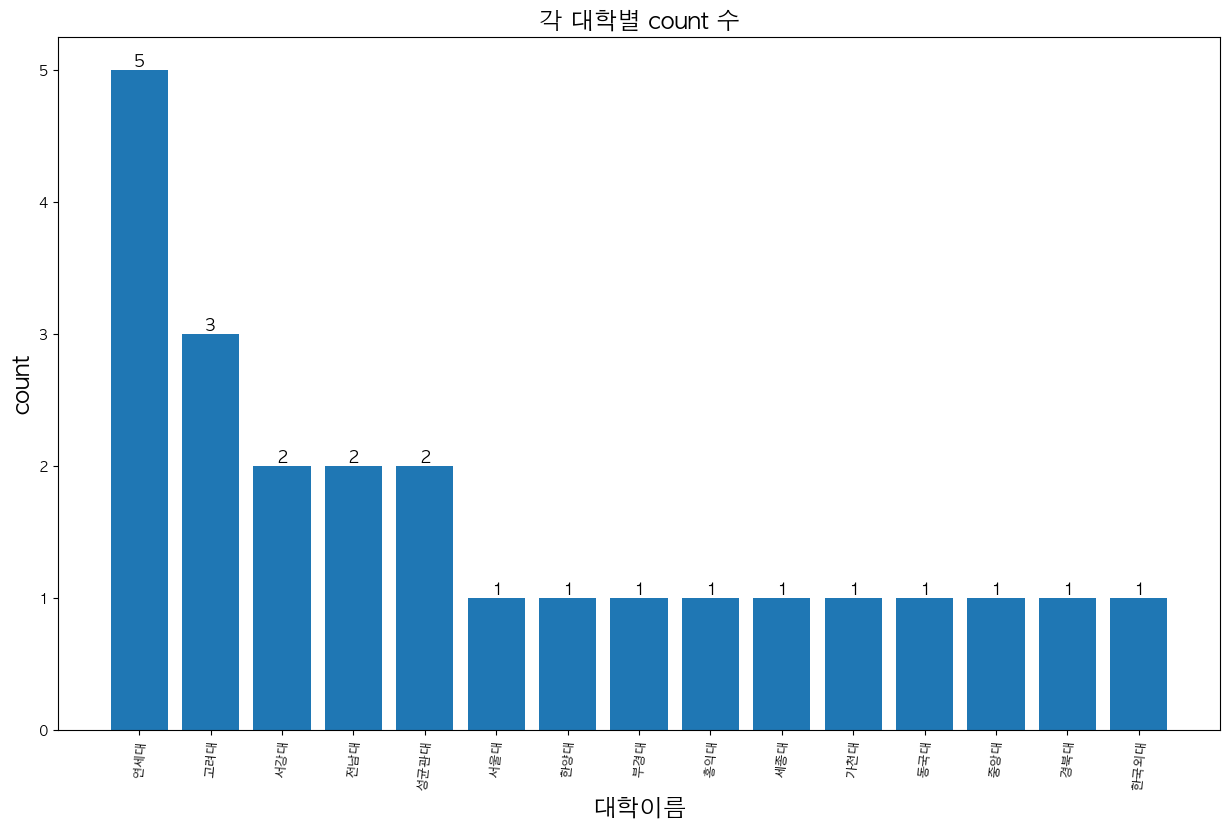

In [79]:
x = dffalse['대학교'].value_counts().index
y = dffalse['대학교'].value_counts().values
plt.figure(figsize=(15,9))
plt.xticks(rotation=85, size= 9)
plt.xlabel('대학이름', size=17)
plt.ylabel('count', size=17)
plt.title('각 대학별 count 수', size=17)
bar = plt.bar(x, y)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 12)

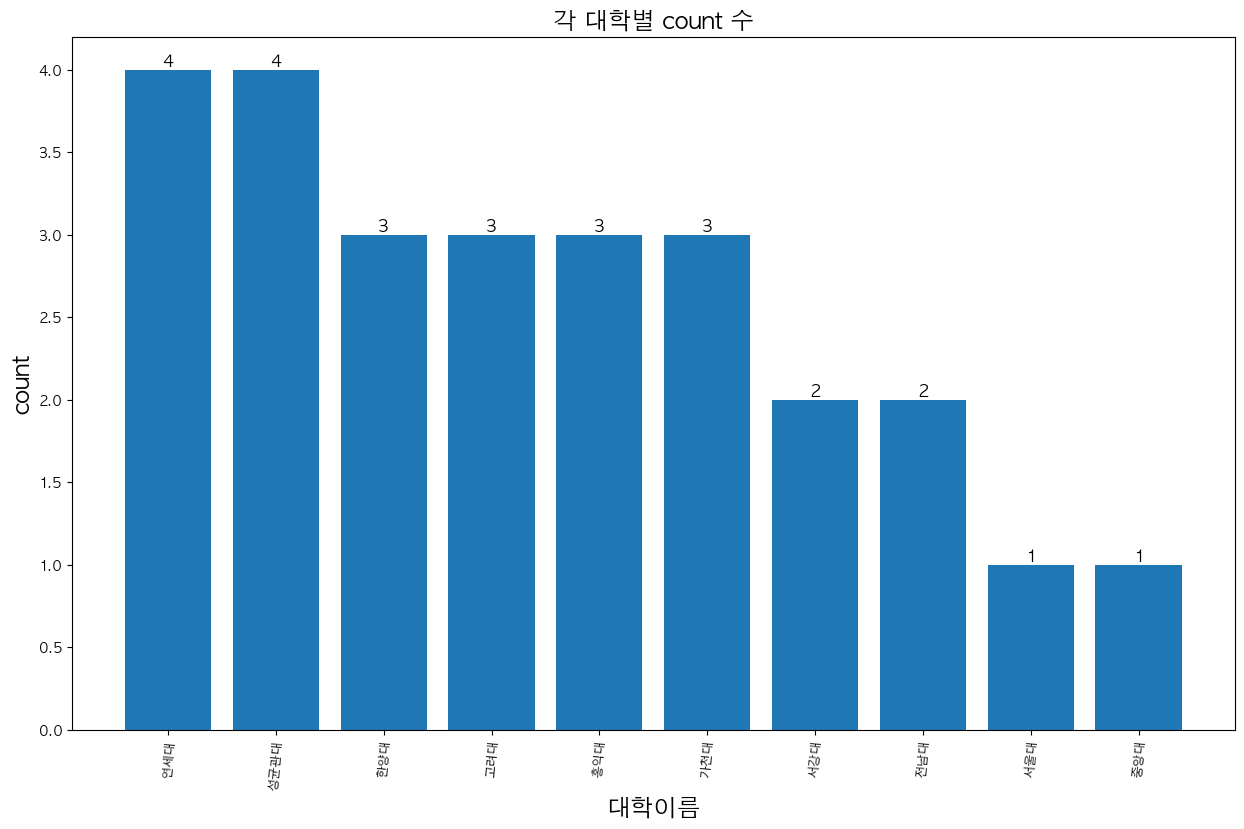

In [28]:
x = dftrue['대학교'].value_counts().index
y = dftrue['대학교'].value_counts().values
plt.figure(figsize=(15,9))
plt.xticks(rotation=85, size= 9)
plt.xlabel('대학이름', size=17)
plt.ylabel('count', size=17)
plt.title('각 대학별 count 수', size=17)
bar = plt.bar(x, y)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 12)

##### true인 사람들의 대학이 좀 더 겹침

In [34]:
#피처별 count 수 그리는 막대그래프 함수
def graph_with_bar(df, col, fsize1 = 9, fsize2 = 5, xlabels=12, ylabels=12, titles = 12, rsize=10, xtick=False):
  x = df[col].value_counts().index
  y = df[col].value_counts().values
  plt.figure(figsize=(fsize1,fsize2))
  if xtick :
    plt.xticks(x)
  plt.xlabel(col, size=xlabels)
  plt.ylabel('count', size=ylabels)
  plt.title(f'{col} 별 count 수', size=titles)
  bar = plt.bar(x, y)

  for rect in bar:
      height = rect.get_height()
      plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = rsize)

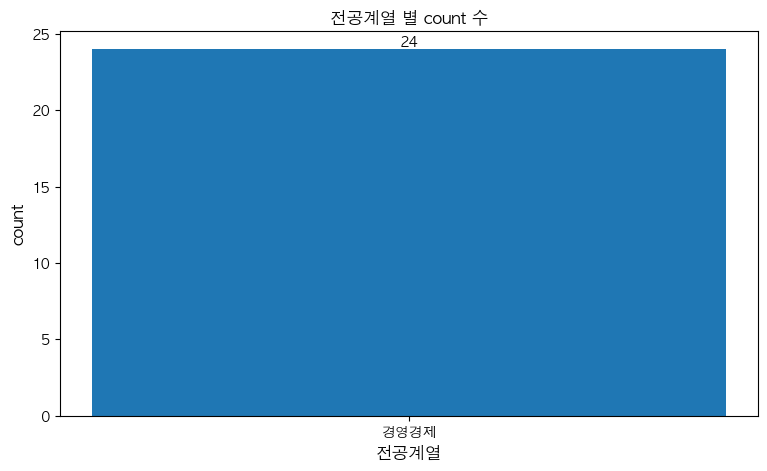

In [38]:
# 전공 계열별 count 막대그래프
def find_department_location(x):
  #전공별 계열 딕셔너리
  department_dict={'경영경제':['회계학', '세무학', '경제학', '국제경영학', '경영학', '무역학', 'MBA', '경제통상학', '경영대학원', '경영대학원MBA', '산업정보학', '금융공학', '국제금융학'],
                   '사회과학':['사회학', '사회과학대학원', '행정학', '정치외교학', '정치학', '신문방송학'],
                   '법률':['법학', '사법학', '정책대학원', '국제정책대학원'],
                   '인문':['불어불문학'],
                   '기타':['교육학', '인적자원개발학'],
                   '자연':['응용통계학', '통계학', '수학'],
                   '공학':['기계공학', '화학공학', '전자계산학', '전자전산학', '전산학', '항공우주학']}

  #키값 찾기
  for key, val in department_dict.items() :
    if x in val :
      return key

#전공 계열 피처 생성
dffalse['전공계열'] = dffalse['전공'].apply(find_department_location)

#그래프 그리기
graph_with_bar(dffalse, '전공계열')

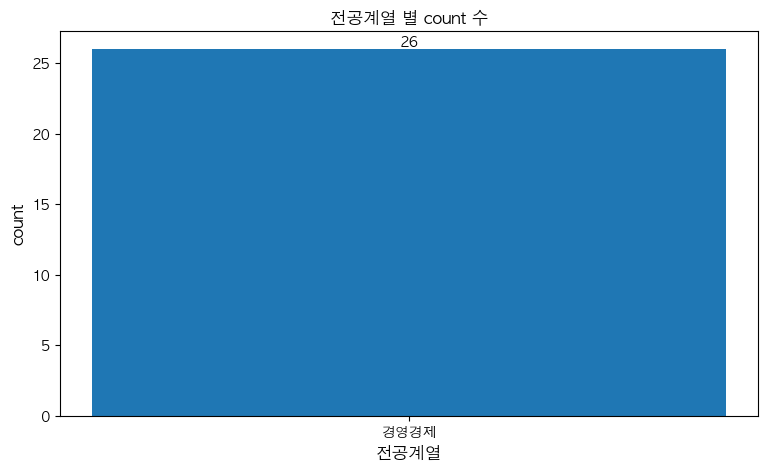

In [39]:

#전공 계열 피처 생성
dftrue['전공계열'] = dftrue['전공'].apply(find_department_location)

#그래프 그리기
graph_with_bar(dftrue, '전공계열')

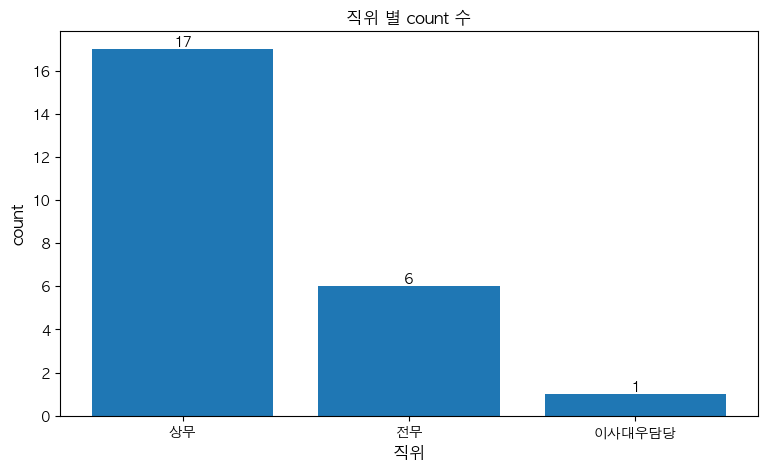

In [40]:
graph_with_bar(dffalse,'직위')

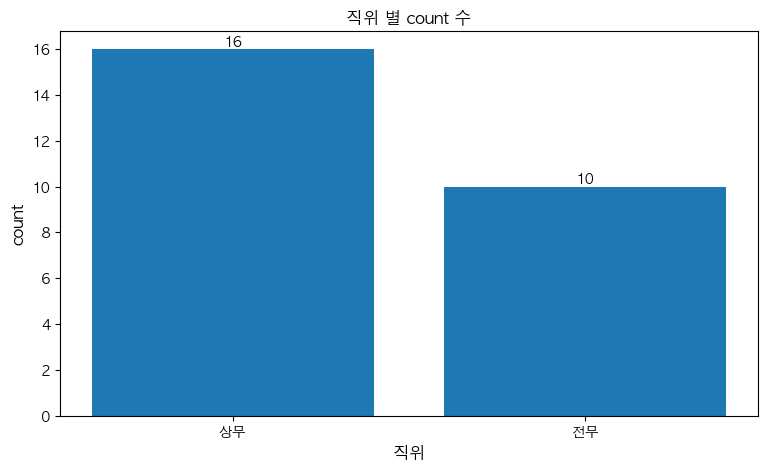

In [41]:
graph_with_bar(dftrue,'직위')

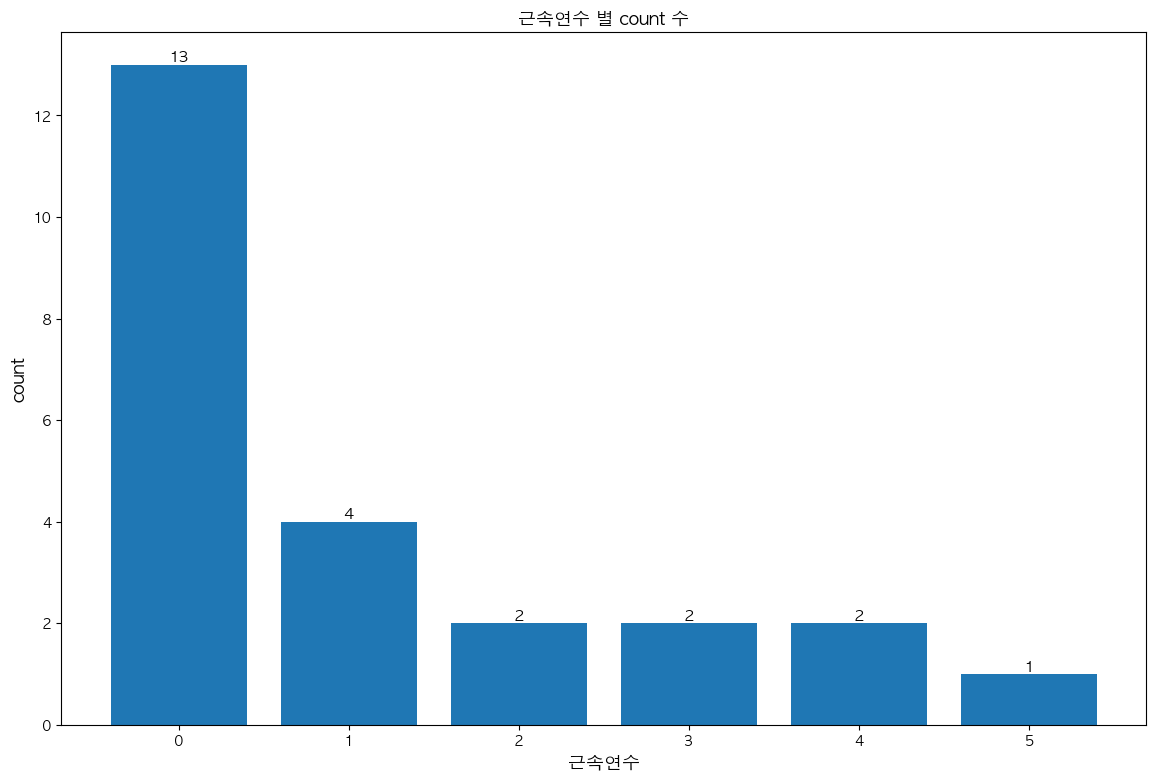

In [42]:
#근속연수 count 막대그래프
graph_with_bar(dffalse,'근속연수', fsize1=14, fsize2=9, xlabels=13, ylabels=13, titles=13, rsize=11, xtick = True)

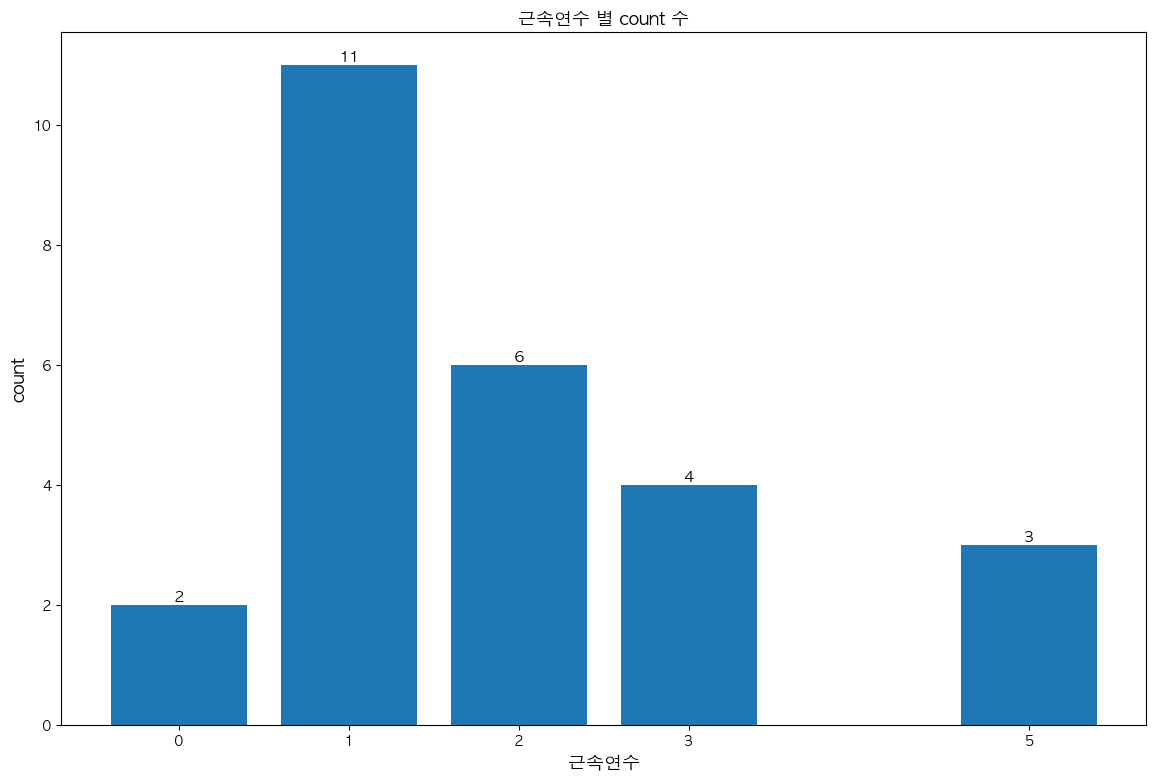

In [43]:
graph_with_bar(dftrue,'근속연수', fsize1=14, fsize2=9, xlabels=13, ylabels=13, titles=13, rsize=11, xtick = True)

In [75]:
#담당업무 같은 계열 별 count 막대그래프
def find_task_location(x):
  #담당업무 딕셔너리
  task_dict={'IT계열': {'IT':['IT부문장', 'IT본부장', 'IT서비스본부장', '디지털부문장', '스마트Biz본부장', 'Operation&Technology본부장'], '정보보호':['정보보호부문장', '정보보호담당']},
             '본사영업':{'Wolesale':['Wholesale부문장','Wholesale영업본부장', 'Wholesale사업단장', 'Trading부문장', 'Trading Center장', 'Sales&Trading총괄', '대외협력담당'],
                     'IB':['IB사업단장', 'IB부문장', 'IB부부문장', 'IB1부문장', 'IB2부문장', 'IPO담당',  'PF부문장', 'PF1본부장', '구조화상품본부장'],
                     '영업':['영업부장']},
             '본사관리':{'리테일':['리테일총괄', 'Club1962센터장','WM추진부문장', 'WM추진본부장', 'WM사업단장'],
                     '리스크':['리스크관리부문장', '리스크관리담당'] ,
                     '경영':['경영전략총괄', '전략지원부문장', '전략지원담당', '경영지원본부장', '경영지원부문장', '경영기획부문장', '경영기획본부장', '기획본부장', '기획본부장 / 투자금융담당', '전략지원부문장/프라이빗라운지 부문장'],
                     '상품':['Product부문장', 'Solution&Product사업단장'],
                     '업무':['업무총괄',  '업무총괄(IB사업단, 고객자산본부 제외)', '업무총괄(IB사업단,고객자산본부 제외)', '업무총괄 (IB사업단,고객자산본부 제외)', '업무총괄(IB사업단, 고객자산본부, 경영지원본부, 정보보호부문, 준법지원부문, 감사부문 제외)'],
                     '금융':['기업금융담당', '스마트금융본부장', '금융주치의추진본부장', '금융주치의사업단장'],
                     '인사,인프라':['인재역량센터장', '인프라관리본부장'],
                     '법률':['준법감시인\n 준법지원부문장', '준법감시인 준법지원부문장', '준법감시인\n준법지원부문장', '준법감시인\n준법지원담당', '준법감시인/준법지원부문장', '준법감시인 / 준법지원담당', 'Advisory본부장'],
                     '감사':['감사위원장', '감사부문장', '감사위원', '상근감사위원', '감사담당'],
                     '언론홍보':['홍보부문장', 'Coverage본부장']},
             '리서치': {'리서치센터':['Research Center장', '리서치센터장', 'Market\n  Solution부문장', 'Research&Strategy본부장', 'Market Solution부문장', 'Market Solution 부문장']},
             '고객':{'고객자산':['고객자산부문장', '고객자산부문 부부문장', '고객자산본부장', '고객자산본부장 / 홍보담당', '고객자산본부장/ 홍보담당', '고객자산본부장/ 홍보부문장', '고객자산본부장/홍보부문장', '고객자산부문장, 홍보부문장', '고객자산부문장\n홍보부문장'],
                   'WM':['서부WM부문장', '서부WM본부장', '재경1WM부문장', '재경1WM본부장', '재경2WM본부장', '재경2WM부문장', '동부WM부문장', '동부WM본부장'],
                   '프라이빗':['프라이빗부문장,\n 나인원프라이빗라운지장', '프라이빗부문장, 나인원프라이빗라운지장', '대신나인원 \n프라이빗라운지장', '프라이빗라운지 부문장 /대신나인원 프라이빗라운지장', '프라이빗부문장, 대신나인원프라이빗라운지장', '프라이빗부문장\n나인원프라이빗라운지장',],
                   '소비자보호':['금융소비자보호부문장\n(COO)', '금융소비자보호부문장(COO)', '금융소비자보호부문장 (COO)', '금융소비자보호 총괄', '금융소비자보호총괄']},
             '기타':{'지점':['강북지역본부장', '강남지역본부장', '강남선릉센터장', '서부지역본부장', '동부지역본부장', '울산지점장'],
                   '비서':['비서실장', '비서/브랜드본부', '비서/브랜드담당'], '공란':['-']}}

   #키값 찾기
  for outerKey in task_dict.keys() :
    for key, val in task_dict[outerKey].items() :
      if x in val :
        return outerKey

#담당업무계열 피처 생성
dffalse['담당업무계열'] = dffalse['담당업무'].apply(find_task_location)
dftrue['담당업무계열'] = dftrue['담당업무'].apply(find_task_location)


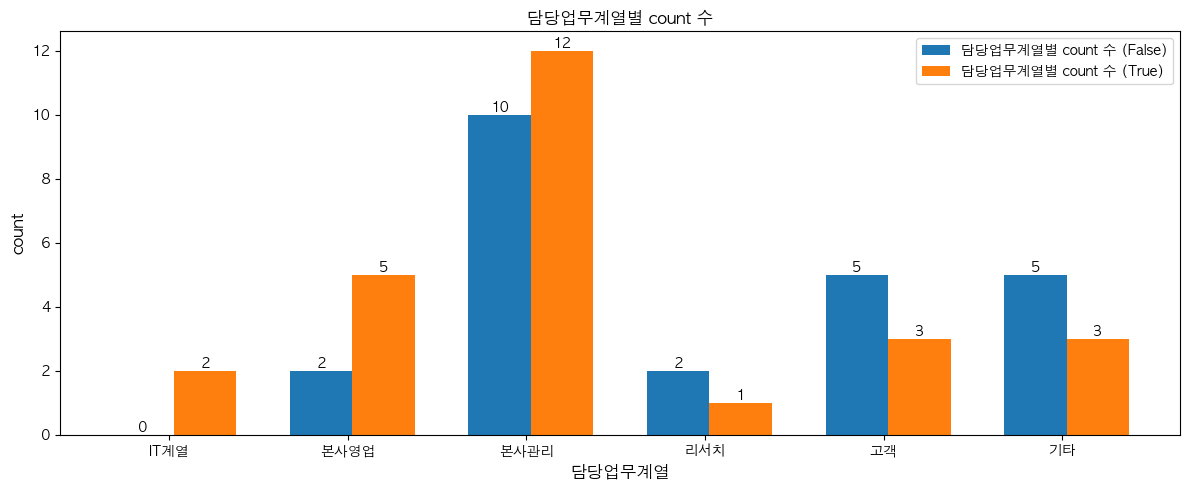

In [74]:
# 담당업무 계열별 count 막대그래프 함수
x_duty = ['IT계열', '본사영업', '본사관리', '리서치', '고객', '기타']
def plot_task_count(dataframe, title, position):
    x = ['IT계열', '본사영업', '본사관리', '리서치', '고객', '기타']
    y = [dataframe[dataframe['담당업무계열'] == 'IT계열'].shape[0],
         dataframe[dataframe['담당업무계열'] == '본사영업'].shape[0],
         dataframe[dataframe['담당업무계열'] == '본사관리'].shape[0],
         dataframe[dataframe['담당업무계열'] == '리서치'].shape[0],
         dataframe[dataframe['담당업무계열'] == '고객'].shape[0],
         dataframe[dataframe['담당업무계열'] == '기타'].shape[0]]

    bar_width = 0.35
    index = np.arange(len(x))

    plt.bar(index + position * bar_width, y, bar_width, label=title)

    for i, v in enumerate(y):
        plt.text(index[i] + position * bar_width, v, str(v), ha='center', va='bottom', size=10)

# 그래프 생성
plt.figure(figsize=(12, 5))

# dffalse에 대한 막대그래프
plot_task_count(dffalse, '담당업무계열별 count 수 (False)', 1)

# dftrue에 대한 막대그래프
plot_task_count(dftrue, '담당업무계열별 count 수 (True)', 2)

# 그래프 설정
plt.xlabel('담당업무계열', size=12)
plt.ylabel('count', size=12)
plt.title('담당업무계열별 count 수', size=12)
plt.xticks(np.arange(len(x_duty)) + 0.5, x_duty)
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


In [47]:
def find_career_location(x):
  # 경력 딕셔너리
  career_dict={1:['대신증권', '대신증권WM사업단장', 'WM추진부문장', '재경1WM부문장', '대신증권중부지역본부장', '기획본부장대신증권', '대신증권분당지점장', '대신증권무거동지점장', '대신증권Capital',
                  '이사대우부본부장', '기획본부장대신증권인재역량센터장', '대신증권인재전략부', '대신증권파생상품운용부장', '대신증권자산운용본부', '대신증권영업기획부장', '대신증권기획실장',
                  '대신증권홍보실', '대신증권브랜드전략실', '대신증권IT개발부장', '대신증권트레이딩시스템부장', '대신증권Global사업본부', '신증권', '기업금융사업단장'], #대신증권
               0:['대신에프앤아이', '대신투자신탁운용', '대신투자신탁운용상무이사', '대신에이엠씨', '대신자산운용', '대신저축은행'], #대신증권 자회사
               2:['메리츠종금증권', '메리츠증권', '미래에셋증권', 'KTB투자증권', 'SC제일은행', '하나금융투자', 'IBK투자증권', 'DB금융투자', 'NH투자증권', 'KB증권', 'LIG손해보험', '굿모닝신한증권', '메릴린치증권',
                  '삼성증권', '동양증권', '한국투자증권', '한국투자증권평촌지점', '대우증권', '대우본부장', '대우증권전략기획본부', '대우증권해외사업부문', '대우증권IB사업부문',
                  '우리투자증권', '우리CS자산운용', '우리투자증권기업금융2팀장', '우리프라이빗에쿼티', '푸르덴셜투자증권', '하이투자증권주식인수팀',  '하이투자증권주식인수팀', 'SBC', 'Bank', '도이치은행'], #타증권사
               3:['금융감독원', '금융위원회', '現)금융위원회', '감사원', '대검찰청', '법무법인', '現)법무법인', '세무법인', '국세청', '중부지방국세청', '서울북부지방검찰청','서울지방국세청장', '서울지방국세청',
                  '제58대', '제22대', '기획재정부', '국세청,관세청,산업통상자원부', '자본시장연구원', '한국조세연구원', '국가청렴위원회', '대한중재인협회', '한국회계정보학회',
                  '금융위원회금융발전심의위원(현)', '금융위원회적극행정심의위원(現)', '안진회계법인',  'L&C세무회계사무소', '변호사정상명법률사무소', '피앤비세무컨설팅', '現)법무법인(유)'], #법,정책
               4:['중앙대', '중앙대학교', '現)중앙대', '연세대학교', 'KAIST', '수원대', '수원대학교', '서울시립대', '現)서울시립대', '학교법인', '現)학교법인', '재단법인', '現)재단법인'], #학교, 교수, 재단
               5:['하비스트', '한국물산', '우리선물', '부영주택', 'LG경제연구원', 'Arthur'] #기타
               }

  #경력 여부 빈리스트 생성
  x_list = [0,0,0,0,0,0] #1번인덱스: 대신증권, 0번인덱스: 대신증권 자회사, 2번인덱스: 타증권사, 3번인덱스: 기타

  #리스트에 각 업종에 종사했었으면 1, 아니면 0
  for career in x :
    for key, val in career_dict.items() :
      if career in val :
        x_list[key]=1
  return x_list

# 리스트의 각 요소에 접근하는 함수
def element_0(lst):
  return lst[0]

def element_1(lst):
  return lst[1]

def element_2(lst):
  return lst[2]

def element_3(lst):
  return lst[3]

def element_4(lst):
  return lst[4]

def element_5(lst):
  return lst[5]

dffalse['주요경력리스트'] = dffalse['주요경력요약'].apply(find_career_location)

#경력 원핫인코딩
dffalse['대신증권자회사종사'] = dffalse['주요경력리스트'].apply(lambda x: element_0(x))
dffalse['대신증권종사'] = dffalse['주요경력리스트'].apply(lambda x: element_1(x))
dffalse['타증권사종사'] = dffalse['주요경력리스트'].apply(lambda x: element_2(x))
dffalse['법정책종사'] = dffalse['주요경력리스트'].apply(lambda x: element_3(x))
dffalse['학교재단종사'] = dffalse['주요경력리스트'].apply(lambda x: element_4(x))
dffalse['기타종사'] = dffalse['주요경력리스트'].apply(lambda x: element_5(x))

In [48]:
dftrue['주요경력리스트'] = dftrue['주요경력요약'].apply(find_career_location)

#경력 원핫인코딩
dftrue['대신증권자회사종사'] = dftrue['주요경력리스트'].apply(lambda x: element_0(x))
dftrue['대신증권종사'] = dftrue['주요경력리스트'].apply(lambda x: element_1(x))
dftrue['타증권사종사'] = dftrue['주요경력리스트'].apply(lambda x: element_2(x))
dftrue['법정책종사'] = dftrue['주요경력리스트'].apply(lambda x: element_3(x))
dftrue['학교재단종사'] = dftrue['주요경력리스트'].apply(lambda x: element_4(x))
dftrue['기타종사'] = dftrue['주요경력리스트'].apply(lambda x: element_5(x))

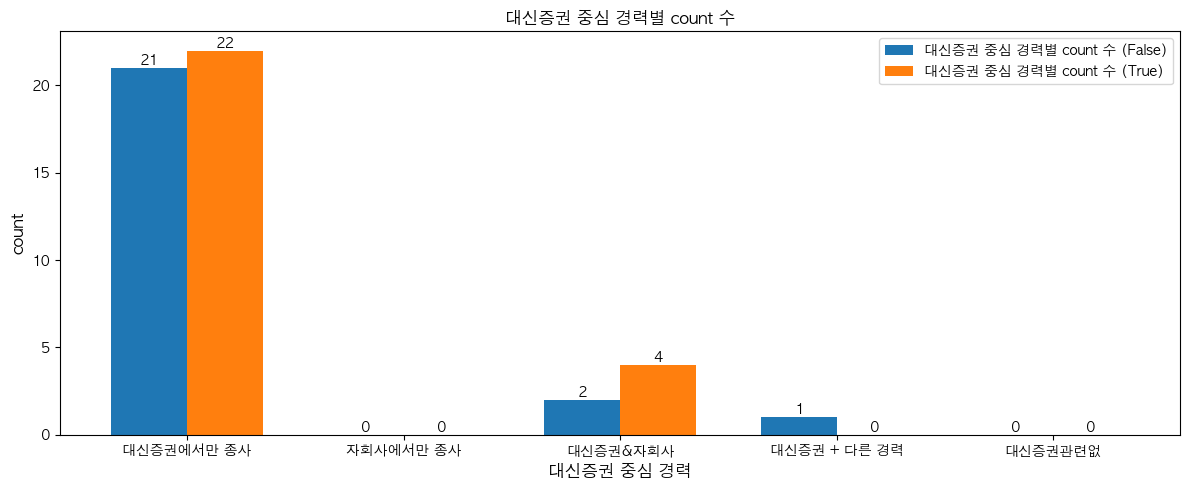

In [68]:
# 대신증권 중심 경력별 count 막대그래프 함수
def plot_career_count(dataframe, title, position):
    x = ['대신증권에서만 종사', '자회사에서만 종사', '대신증권&자회사', '대신증권 + 다른 경력', '대신증권관련없']
    y = [dataframe['대신증권에서만 종사'].sum(), dataframe['자회사에서만 종사'].sum(), dataframe['대신증권&자회사'].sum(), dataframe['대신증권 + 다른 경력'].sum(), dataframe['대신증권관련없'].sum()]

    bar_width = 0.35
    index = np.arange(len(x))

    plt.bar(index + position * bar_width, y, bar_width, label=title)

    for i, v in enumerate(y):
        plt.text(index[i] + position * bar_width, v, str(v), ha='center', va='bottom', size=10)

# 그래프 생성
plt.figure(figsize=(12, 5))

# dffalse에 대한 막대그래프
plot_career_count(dffalse, '대신증권 중심 경력별 count 수 (False)', -0.5)

# dftrue에 대한 막대그래프
plot_career_count(dftrue, '대신증권 중심 경력별 count 수 (True)', 0.5)

# 그래프 설정
plt.xlabel('대신증권 중심 경력', size=12)
plt.ylabel('count', size=12)
plt.title('대신증권 중심 경력별 count 수', size=12)
plt.xticks(np.arange(len(x)),x)
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


In [54]:
dffalse['의결권 있는 주식수'].describe()

count       24.000000
mean      4548.500000
std       9182.047181
min          0.000000
25%          0.000000
50%         25.000000
75%       5442.500000
max      43189.000000
Name: 의결권 있는 주식수, dtype: float64

In [55]:
dftrue['의결권 있는 주식수'].describe()

count       26.000000
mean      5529.807692
std      10308.516456
min          0.000000
25%        326.750000
50%       2890.000000
75%       5220.750000
max      52540.000000
Name: 의결권 있는 주식수, dtype: float64